In [1]:
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch]
!pip install transformers -U
!pip uninstall transformers accelerate
!pip install transformers accelerate
!pip install torch -U
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-no

In [2]:
from accelerate import Accelerator
accelerator = Accelerator()
print("Accelerate device:", accelerator.device)

Accelerate device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/buggy/bugs'
with open(file_path, 'r') as file:
    sample_content = file.read(1000)

sample_content

'[\n  {\n    "fixCommitSHA1": "e1b4341bcf2075abbb30b3336aa889a04f683cd4",\n    "fixCommitParentSHA1": "e15dbdf6aceac531383d22369d7f09b40106f06e",\n    "bugFilePath": "modules/activiti-secure-service-tasks/src/test/java/org/activiti/test/serviceTask/secure/SecureShellTaskTest.java",\n    "fixPatch": "diff --git a/modules/activiti-secure-service-tasks/src/test/java/org/activiti/test/serviceTask/secure/SecureShellTaskTest.java b/modules/activiti-secure-service-tasks/src/test/java/org/activiti/test/serviceTask/secure/SecureShellTaskTest.java\\nindex e288bae..a5fa9b4 100644\\n--- a/modules/activiti-secure-service-tasks/src/test/java/org/activiti/test/serviceTask/secure/SecureShellTaskTest.java\\n+++ b/modules/activiti-secure-service-tasks/src/test/java/org/activiti/test/serviceTask/secure/SecureShellTaskTest.java\\n@@ -38,7 +38,7 @@\\n         }\\n \\n         try {\\n-            runtimeService.startProcessInstanceByKey(\\"shellCommandStart\\");\\n+            runtimeService.startProcessIn

In [5]:
import torch
import gc


if torch.cuda.is_available():
    torch.cuda.empty_cache()


gc.collect()

torch.cuda.reset_peak_memory_stats()

print("GPU memory cleared")
import time
import json
import pandas as pd
import numpy as np
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch
def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]
import numpy as np
import networkx as nx
from sklearn.metrics import accuracy_score
from transformers import GPT2Tokenizer, GPT2LMHeadModel



def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}

def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Example of buggy code: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code: {dataset['train'][0]['fixed_code']}\n")

def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")


def generate_patch(description, model, tokenizer, device):
    prompt = f"Fix this code: {description}"
    inputs = tokenizer.encode_plus(prompt, return_tensors="pt", max_length=1024, truncation=True, padding="max_length")

    inputs = {k: v.to(device) for k, v in inputs.items()}

    prompt_length = inputs['input_ids'].shape[1]
    max_length = 1024
    max_new_tokens = max(1, max_length - prompt_length)
    if max_new_tokens > 0:
        outputs = model.generate(**inputs, max_length=max_length, max_new_tokens=max_new_tokens, num_beams=5, early_stopping=True)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)
    else:
        return "No space to generate new tokens; consider reducing the prompt length or changing model configurations."



def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/bugs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.05))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.05)))
        })

        display_dataset_statistics(dataset)

        tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = GPT2LMHeadModel.from_pretrained('gpt2-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=1e-2,
            per_device_train_batch_size=1,
            gradient_accumulation_steps=16,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )


        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        # Generate and print patches for these examples
        for i, description in enumerate(example_descriptions):
            patch = generate_patch(description, model, tokenizer, device)
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()



GPU memory cleared


<ipython-input-5-c033af5fb309>:40: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  return load_metric("accuracy", trust_remote_code=True)


Dataset Statistics:
Total samples: 6862
Training samples: 6176
Validation samples: 686
Example of buggy code: throw new MetaException(PUBLIC + " role implictly exists. It can't be created.");
Example of fixed code: throw new MetaException(PUBLIC + " role implicitly exists. It can't be created.");



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,272628900167.679993,nan


Epoch,Training Loss,Validation Loss
1,272628900167.679993,nan
2,2835421265.920000,nan
3,227001589.760000,nan


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Both `max_new_tokens` (=1) and `max_length`(=1024) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Results Statistics:
eval_loss: nan
eval_runtime: 4.1967
eval_samples_per_second: 163.461
eval_steps_per_second: 20.492
epoch: 3.0
Execution Time: 2239.46 seconds


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Both `max_new_tokens` (=1) and `max_length`(=1024) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Example 1:
Buggy Code: private void buildProject(String projectDir) {
Generated Patch: Fix this code: private void buildProject(String projectDir) {



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Both `max_new_tokens` (=1) and `max_length`(=1024) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Example 2:
Buggy Code: -- a/core/server/master/src/main/java/alluxio/master/meta/AlluxioMasterRestServiceHandler.java
Generated Patch: Fix this code: -- a/core/server/master/src/main/java/alluxio/master/meta/AlluxioMasterRestServiceHandler.java

Example 3:
Buggy Code: spaceInfoInDir.put(dir, new Pair<Long, Long>(
Generated Patch: Fix this code: spaceInfoInDir.put(dir, new Pair<Long, Long>(



Dataset Statistics:
Total samples: 2744
Training samples: 2470
Validation samples: 274
Example of buggy code: public static enum ThriftCompressionType {
Example of fixed code: static enum ThriftCompressionType {



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/2470 [00:00<?, ? examples/s]

Map:   0%|          | 0/274 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
0,0.000000,7.474967
1,0.000000,7.474967
2,0.000000,7.474967


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Both `max_new_tokens` (=1) and `max_length`(=1024) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Results Statistics:
eval_loss: 7.474966526031494
eval_runtime: 1.7277
eval_samples_per_second: 158.594
eval_steps_per_second: 20.258
epoch: 2.9927125506072874
Execution Time: 467.49 seconds


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Both `max_new_tokens` (=1) and `max_length`(=1024) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Both `max_new_tokens` (=1) and `max_length`(=1024) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


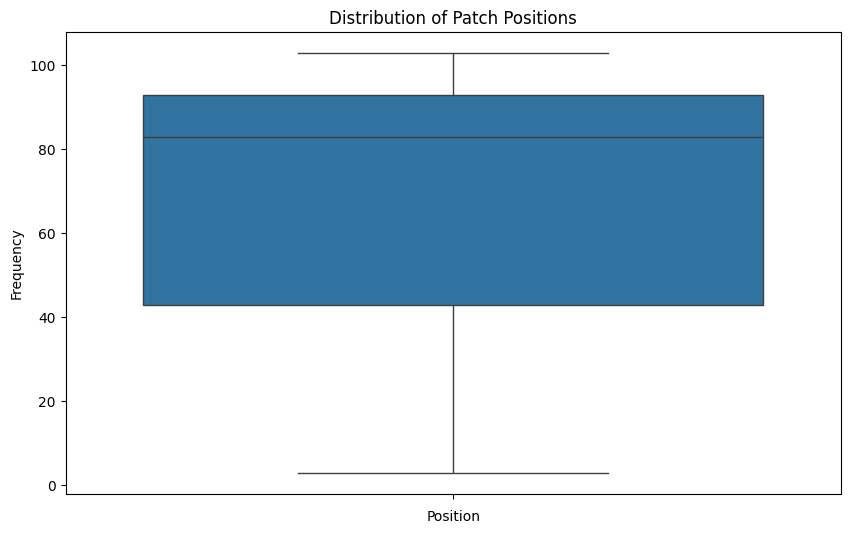

Example 1:
Buggy Code: location);
Generated Patch: Fix this code: location);

Example 2:
Buggy Code: -- a/components-starter/camel-core-starter/src/main/java/org/apache/camel/impl/springboot/SerializationDataFormatAutoConfiguration.java
Generated Patch: Fix this code: -- a/components-starter/camel-core-starter/src/main/java/org/apache/camel/impl/springboot/SerializationDataFormatAutoConfiguration.java

Example 3:
Buggy Code: logger.debug("didn't post update to eventPublisher, because state did not changed for item "
Generated Patch: Fix this code: logger.debug("didn't post update to eventPublisher, because state did not changed for item "



In [12]:
import time
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch
import time

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import json
import pandas as pd
import numpy as np
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric
import torch
def parse_diff(diff):
    buggy_code = []
    fixed_code = []
    lines = diff.split('\n')
    for line in lines:
        if line.startswith('-'):
            buggy_code.append(line[1:].strip())
        elif line.startswith('+'):
            fixed_code.append(line[1:].strip())
    min_length = min(len(buggy_code), len(fixed_code))
    return buggy_code[:min_length], fixed_code[:min_length]
import numpy as np
import networkx as nx
from sklearn.metrics import accuracy_score
from transformers import GPT2Tokenizer, GPT2LMHeadModel



def load_accuracy_metric():
    return load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'eval_accuracy': accuracy_metric.compute(predictions=predictions, references=labels)}

def load_data(filepath):
    try:
        with open(filepath, 'r') as file:
            data = json.load(file)
        buggy_codes, fixed_codes = [], []
        for item in data:
            b_code, f_code = parse_diff(item['fixPatch'])
            buggy_codes.extend(b_code)
            fixed_codes.extend(f_code)
        df = pd.DataFrame({'buggy_code': buggy_codes, 'fixed_code': fixed_codes})
        return Dataset.from_pandas(df)
    except Exception as e:
        print(f"Failed to load data: {e}")
        return None

def setup_tokenization(tokenizer, max_length=128):
    def tokenize_function(examples):
        input_encodings = tokenizer(examples['buggy_code'], truncation=True, padding="max_length", max_length=max_length)
        target_encodings = tokenizer(examples['fixed_code'], truncation=True, padding="max_length", max_length=max_length)
        return {"input_ids": input_encodings.input_ids, "attention_mask": input_encodings.attention_mask, "labels": target_encodings.input_ids}
    return tokenize_function

def display_dataset_statistics(dataset):
    print("Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Example of buggy code: {dataset['train'][0]['buggy_code']}")
    print(f"Example of fixed code: {dataset['train'][0]['fixed_code']}\n")

def display_result_statistics(results, execution_time):
    print("Results Statistics:")
    for key, value in results.items():
        print(f"{key}: {value}")
    print(f"Execution Time: {execution_time:.2f} seconds")


def generate_patch(description, model, tokenizer, device):
    prompt = f"Fix this code: {description}"
    inputs = tokenizer.encode_plus(prompt, return_tensors="pt", max_length=1024, truncation=True, padding="max_length")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    prompt_length = inputs['input_ids'].shape[1]
    max_length = 1024
    max_new_tokens = max(1, max_length - prompt_length)

    if max_new_tokens > 0:
        outputs = model.generate(**inputs, max_length=max_length, max_new_tokens=max_new_tokens, num_beams=5, early_stopping=True)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)
    else:
        return "No space to generate new tokens; consider reducing the prompt length or changing model configurations."
def simulate_patch_position(description, patch):
    """
    Simulate a score for where the patch is applied. For illustration,
    let's assume this function returns a random position based on the length of the description.
    """
    return np.random.randint(0, len(description))
def generate_patches_and_positions(descriptions, model, tokenizer, device):
    positions = []
    patches = []
    for description in descriptions:
        patch = generate_patch(description, model, tokenizer, device)
        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
    return patches, positions
def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()
def main():
    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/bugs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.02))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.02)))
        })

        display_dataset_statistics(dataset)

        tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = GPT2LMHeadModel.from_pretrained('gpt2-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)


        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=2e-2,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]  # Convert numpy.int64 to Python int
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        patches, positions = generate_patches_and_positions(example_descriptions, model, tokenizer, device)
        plot_positions(positions)

        for i, (description, patch) in enumerate(zip(example_descriptions, patches)):
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()


Dataset Statistics:
Total samples: 6862
Training samples: 6176
Validation samples: 686
Example of buggy code: private final PassFactory ignoreCajaProperties =
Example of fixed code: final PassFactory ignoreCajaProperties =



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.555100,0.547564


Epoch,Training Loss,Validation Loss
1,0.555100,0.547564
2,0.436400,0.497472
3,0.417200,0.482166


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Results Statistics:
eval_loss: 0.4821662902832031
eval_runtime: 4.2497
eval_samples_per_second: 161.424
eval_steps_per_second: 20.237
epoch: 3.0
Execution Time: 1273.98 seconds


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


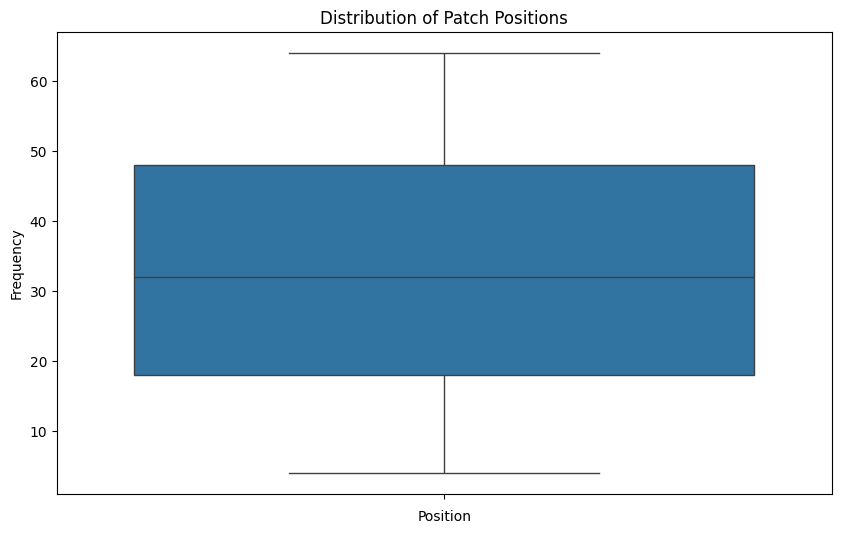

Max time: 0.1786s, Min time: 0.0980s, Average time: 0.1266s
Example 1:
Buggy Code: public void background(String keyword, String name, String description, int line) {
Generated Patch: public void background(String keyword, String name, String description, int line) {

Example 2:
Buggy Code: -- a/flink-libraries/flink-table-common/src/main/java/org/apache/flink/table/descriptors/DescriptorProperties.java
Generated Patch: -- a/flink-libraries/flink-table-common/src/main/java/org/apache/flink/table/descriptors/DescriptorProperties.java

Example 3:
Buggy Code: assertEquals("Starting directory does not exist: target/file/foo", e.getMessage());
Generated Patch: assertEquals("Starting directory does not exist: target/file/foo", e.getMessage());



In [13]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict, load_metric

def simulate_patch_position(description, patch):
    return np.random.randint(0, len(description))

def generate_patch(description, model, tokenizer, device):
    inputs = tokenizer(description, return_tensors="pt", max_length=1024, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(inputs['input_ids'], max_length=150, num_beams=5, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def generate_patches_and_positions(descriptions, model, tokenizer, device, time_budget):
    positions = []
    patches = []
    timing_data = []
    start_time = time.time()

    for description in descriptions:
        if time.time() - start_time > time_budget:
            print("Time budget exceeded, stopping patch generation.")
            break

        patch_start_time = time.time()
        patch = generate_patch(description, model, tokenizer, device)
        patch_end_time = time.time()

        position = simulate_patch_position(description, patch)
        positions.append(position)
        patches.append(patch)
        timing_data.append(patch_end_time - patch_start_time)

    return patches, positions, timing_data

def plot_positions(positions):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=positions)
    plt.title("Distribution of Patch Positions")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.show()

def summarize_timing_data(timing_data):
    max_time = max(timing_data)
    min_time = min(timing_data)
    avg_time = np.mean(timing_data)
    print(f"Max time: {max_time:.4f}s, Min time: {min_time:.4f}s, Average time: {avg_time:.4f}s")

def main():

    start_time = time.time()
    accuracy_metric = load_accuracy_metric()

    dataset = load_data('/content/drive/MyDrive/buggy/bugs')
    if dataset is not None:
        dataset = dataset.train_test_split(test_size=0.1)
        dataset = DatasetDict({
            'train': dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train']) * 0.05))),
            'validation': dataset['test'].shuffle(seed=42).select(range(int(len(dataset['test']) * 0.05)))
        })

        display_dataset_statistics(dataset)

        tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = GPT2LMHeadModel.from_pretrained('gpt2-large')
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)


        tokenized_datasets = dataset.map(setup_tokenization(tokenizer), batched=True)

        training_args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            learning_rate=1e-5,
            per_device_train_batch_size=2,
            gradient_accumulation_steps=8,
            num_train_epochs=3,
            weight_decay=0.01,
            save_steps=500,
            logging_steps=50,
            fp16=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['validation']
        )

        trainer.train()
        results = trainer.evaluate()
        execution_time = time.time() - start_time

        display_result_statistics(results, execution_time)

        time_budget = 60
        example_indices = np.random.choice(len(tokenized_datasets['validation']), 3, replace=False)
        example_indices = [int(i) for i in example_indices]
        example_descriptions = [tokenized_datasets['validation'][i]['buggy_code'] for i in example_indices]

        patches, positions, timing_data = generate_patches_and_positions(example_descriptions, model, tokenizer, device, time_budget)
        plot_positions(positions)
        summarize_timing_data(timing_data)

        for i, (description, patch) in enumerate(zip(example_descriptions, patches)):
            print(f"Example {i+1}:")
            print(f"Buggy Code: {description}")
            print(f"Generated Patch: {patch}\n")

if __name__ == "__main__":
    main()
